THIS WAS MADE PUBLICLY VIEWABLE 1/23/24.

In this study, ChatGPT-3 and Shel Silverstein poems were used to compare AI detection capabilities to human abilities. Besides the code written here, I conducted 2 different survey's to see how good people are at determining if poems were AI generated or not. 1 of the human surveys included examples of AI and human poems and the other style of survey did not. With the results of my study, I concluded that for the specfic data used and people surveyed, that many different machine learning techniques outperformed human results, and that specifically trained algorithms on relevant data performed best.

Check if GPU is operating (could also be run with a cpu and

---

some patience)

In [2]:
import torch

use_gpu = True # Change this flag as needed

if use_gpu:
  # Check the GPU is detected
  if not torch.cuda.is_available():
    print("ERROR: No GPU detected. Please add a GPU; if you're using Colab, use their UI.")
    assert False
  # Get the GPU device name.
  device_name = torch.cuda.get_device_name()
  n_gpu = torch.cuda.device_count()
  print("Found device: {}, n_gpu: {}".format(device_name, n_gpu))
else:
  # Check that no GPU is detected
  if torch.cuda.is_available():
    print("ERROR: GPU detected.")
    print("Remove the GPU or set the use_gpu flag to True.")
    assert False
  print("No GPU found. Using CPU.")
  print("WARNING: Without a GPU, your code will be extremely slow.")

Found device: Tesla T4, n_gpu: 1


Import/install necessary tools

In [3]:
import scipy

def get_confidence_intervals(accuracy, sample_size, confidence_level):
  """ calling this with arguments (0.8, 100, .95) returns
  the lower and upper bounds of a 95% confidence interval
  around the accuracy of 0.8 on a test set of size 100."""
  z_score = -1 * scipy.stats.norm.ppf((1-confidence_level)/2)
  standard_error = numpy.sqrt(accuracy * (1-accuracy) / sample_size)
  lower_ci = accuracy - standard_error*z_score
  upper_ci = accuracy + standard_error*z_score
  return lower_ci, upper_ci

In [4]:
!pip install transformers==4.24.0
!pip install datasets==2.7.1
!pip install evaluate==0.3.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 39.4 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.15.2
    Uninstalling tokenizers-0.15.2:
      Successfully uninstalled tokenizers-0.15.2
  Attempting uninstall: transformers
    Found existing installation: transformers 4.37.2
    Uninstalling transformers-4.37.2:
      Successfully uninstalled transformers-4.37.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 451.7/451.7 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.0 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━

In [5]:
import numpy
import pandas as pd
import io
import random
import matplotlib.pyplot as plt
import sklearn
from nltk.corpus import stopwords
from collections import defaultdict
import math

In [6]:
pretrained_bert = 'bert-base-uncased'

Upload 2 files. One is a list of poems by Shel Silverstein, the other is a list of poems by ChatGPT-3 created with a 1 to 1 correspondence to the Shel Silverstein poems.
The prompt given to ChatGPT was the following:
"Write 10 poems in similar style to the following 10 poems: \n (10 poems)"
The poems were split into groups of 10 because of ChatGPT's maximum prompt length, each prompt was given to a newly instantiated version of ChatGPT via OpenAI.

In [7]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  AIPoems = pd.read_csv(io.BytesIO(uploaded[fn]))

uploaded2 = files.upload()

for fn in uploaded2.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded2[fn])))
  humanPoems = pd.read_csv(io.BytesIO(uploaded2[fn]))


#upload AI poems with sperator first and then Human poems with separator

Saving AIPoemsWithSeparator.csv to AIPoemsWithSeparator.csv
User uploaded file "AIPoemsWithSeparator.csv" with length 9214 bytes


Saving humanPoemsWithSeparator.csv to humanPoemsWithSeparator.csv
User uploaded file "humanPoemsWithSeparator.csv" with length 8766 bytes


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Split data into training, testing, and validation splits, with error checking

In [9]:
def split_list(alist, wanted_parts=1):
    length = len(alist)
    return [ alist[i*length // wanted_parts: (i+1)*length // wanted_parts]
             for i in range(wanted_parts) ]



def testTrainDevSplit(l, seed=0):
    random.seed(seed)
    random.shuffle(l)
    train = l[:int(len(l) * .75)]
    dev = l[int(len(l) * .75):int(len(l) * .875)]
    test = l[int(len(l) * .875):]
    return train, dev, test

def testTrainSplit(l, seed=0):
    random.seed(seed)
    random.shuffle(l)
    train = l[:int(len(l) * .80)]
    test = l[int(len(l) * .80):]
    return train, test



head = humanPoems.head(n=1)
headString = head.to_string()
firstHumanPoem = headString.split("#")[0]
humanPoemsList = humanPoems.values.tolist()
hPoems = []
hPoems.append(firstHumanPoem)
for l in humanPoemsList:
  hPoems.append(l[0])


humanPoemsTrain, humanPoemsDev, humanPoemsTest = testTrainDevSplit(hPoems)
#humanPoemsTrain, humanPoemsTest = testTrainSplit(hPoems)

print(len(humanPoemsTrain))
#print(len(humanPoemsDev))
print(len(humanPoemsTest))

AIPoemHead = AIPoems.head(n=1)
AIheadString = AIPoemHead.to_string()
firstAIPoem = AIheadString.split("#")[0]
AIPoemsList = AIPoems.values.tolist()
aPoems = []
aPoems.append(firstAIPoem)
for l in AIPoemsList:
  aPoems.append(l[0])

AIPoemsTrain, AIPoemsDev, AIPoemsTest = testTrainDevSplit(aPoems)
#AIPoemsTrain, AIPoemsTest = testTrainSplit(aPoems)

print(len(AIPoemsTrain))
#print(len(humanPoemsDev))
print(len(AIPoemsTest))


def printpoems():
    print("Human Poem Training Set first 10:")
    for i in range(len(humanPoemsTrain[:10])):
        print("Poem " + str(i) + ": ")
        print(humanPoemsTrain[i])
    print("AI Poem Training Set first 10:")
    for i in range(len(AIPoemsTrain[:10])):
        print("Poem " + str(i) + ": ")
        print(AIPoemsTrain[i])
    print("Human Poem Test Set:")
    for i in range(len(humanPoemsTest)):
        print("Poem " + str(i) + ": ")
        print(humanPoemsTest[i])
    print("AI Poem Test Set:")
    for i in range(len(AIPoemsTest)):
        print("Poem " + str(i) + ": ")
        print(AIPoemsTest[i])

#printpoems()

30
5
30
5


Combine Human and AI poem splits into single splits with both

In [10]:
NUM_TRAIN = len(humanPoemsTrain) + len(AIPoemsTrain)
NUM_TEST = len(humanPoemsTest) + len(AIPoemsTest)
NUM_DEV = len(humanPoemsDev) + len(AIPoemsDev)

"""def build_split(dataset, n_samples, offset=0):
  class_size = n_samples // 2
  # Get negative samples
  texts = dataset['text'][offset:class_size+offset]
  labels = dataset['label'][offset:class_size+offset]
  # Get positive samples
  texts += dataset['text'][-offset-class_size:]
  labels += dataset['label'][-offset-class_size:]
  if offset:
    texts = texts[:-offset]
    labels = labels[:-offset]
  return texts, labels
"""
def build_split(hPoems, aPoems, n_samples, offset=0):
  class_size = n_samples // 2
  # Get negative samples
  texts = hPoems.copy()
  labels = [0] * len(hPoems)
  # Get positive samples
  texts += aPoems
  labels += [1] * len(aPoems)
  if offset:
    texts = texts[:-offset]
    labels = labels[:-offset]
  return texts, labels


# Training data
train_texts, train_labels = build_split(humanPoemsTrain, AIPoemsTrain, NUM_TRAIN)
test_texts, test_labels = build_split(humanPoemsTest, AIPoemsTest, NUM_TEST)
dev_texts, dev_labels = build_split(humanPoemsDev, AIPoemsDev, NUM_DEV)

print("train split: {} reviews".format(len(train_labels)))
#print("dev split: {} reviews".format(len(dev_labels)))
print("test split: {} reviews".format(len(test_labels)))

train split: 60 reviews
test split: 10 reviews


Initialize pretrained Bert

In [11]:
from transformers import AutoTokenizer, BertModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained(pretrained_bert)
model = BertModel.from_pretrained(pretrained_bert,
                                  output_hidden_states=True).to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Use Bert's 12 layers of CLS tokens as quantitative data to represent each poem by.

In [12]:
def extract_bert_features(input_texts):
  features = []
  for i, text in enumerate(input_texts):
    input = tokenizer.encode(text, truncation=True,
                             return_tensors="pt").to(device)
    hidden_states = model(input).hidden_states
    cls_hidden_states = [layer[:, 0, :] for layer in hidden_states[1:]]  # Exclude the embedding layer
    feature = torch.stack(cls_hidden_states)
    feature = feature.detach().cpu().numpy()
    feature = numpy.squeeze(feature, axis=1)
    features.append(feature)

    assert feature.shape == (12, 768)
  return numpy.stack(features)

In [13]:
# Extract features for the training and test sets
from timeit import default_timer as timer

start = timer()
train_features = extract_bert_features(train_texts)
test_features = extract_bert_features(test_texts)
end = timer()
print("Extracted features in {:.1f} minutes".format((end-start)/60))
print(train_features.shape)
print(test_features.shape)
print(NUM_TRAIN)
print(NUM_TEST)

assert train_features.shape == (NUM_TRAIN, 12, 768)
assert test_features.shape == (NUM_TEST, 12, 768)

Extracted features in 0.0 minutes
(60, 12, 768)
(10, 12, 768)
60
10


Visualize CLS tokens of the poems for separability. Start by concatenating the 12 tokens for each poem to get a length 9216 vector for each poem.
Use principal component analysis to compress the data into few dimensions, and graph pairs of these dimensions.
The results show significant separability between the CLS tokens of poems written by Shel Silverstein and ChatGPTs imitations. These results imply that machine learning algorithms should be able to perform reasonablly well at determining whether the poem was AI or not.

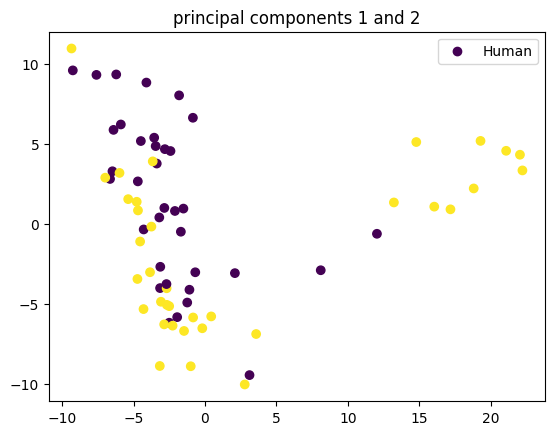

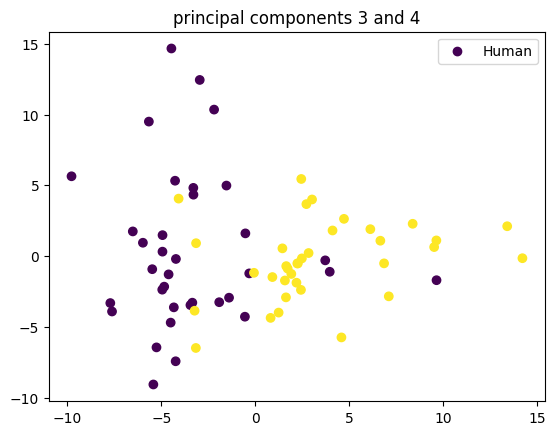

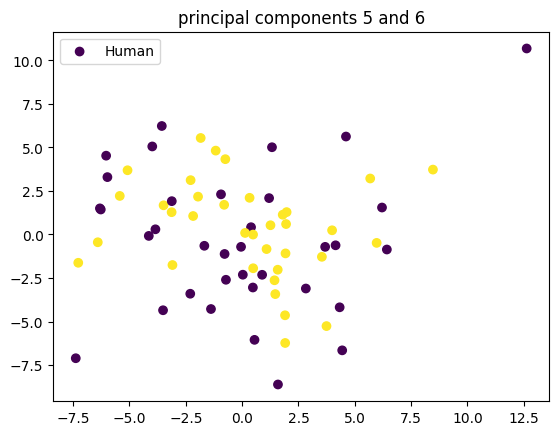

In [34]:
from sklearn.decomposition import PCA

def plot_pca(features, labels, title):
  features = pca.transform(features)
  plt.scatter(features[:, 0], features[:, 1], c=labels)
  plt.title(title)
  #plt.legend(labels)
  plt.legend(["Human", "AI"])
  #plt.savefig('/content/drive/My Drive/AIHumanPCA')
  plt.show()
  #files.download(title + ".png")

def plot_pca12(features, labels, title):
    pca = PCA(n_components=12)
    pca.fit(features)
    pca_features = pca.transform(features)
    for i in range(0, 10, 2):
        plt.figure()
        plt.scatter(pca_features[:, i], pca_features[:, i+1], c=labels)
        plt.title("principal components " + str(i + 1) +  " and " + str(i + 2))
        plt.legend(["Human", "AI"])
        plt.show()

def plot_pca_top_6(features, labels, title):
    pca = PCA(n_components=6)
    pca.fit(features)
    pca_features = pca.transform(features)
    for i in range(0, 5, 2):
       plt.figure()
       plt.scatter(pca_features[:, i], pca_features[:, i + 1], c=labels)
       plt.title("principal components " + str(i + 1) +  " and " + str(i + 2))
       plt.legend(["Human", "AI"])
       plt.show()




all_features = numpy.concatenate((train_features, test_features))
all_labels = numpy.concatenate((train_labels, test_labels))
pca = PCA(n_components=2)
pca.fit(all_features.reshape(-1, 12*768))

plot_pca_top_6(all_features.reshape(-1, 12*768), all_labels, "All Features")


Train a logistic regression model on each of the 12 CLS tokens per poem. This step was taken to see if the different layers offered differing levels of use as opposed to starting out with them all concatenated.

In [15]:
from sklearn.linear_model import LogisticRegression
layerscores = []

for i in range(12):
  y_pred = None

  lr_model = LogisticRegression(max_iter=1000)
  train_layer_features = train_features[:, i, :]
  test_layer_features = test_features[:, i, :]

  lr_model.fit(train_layer_features, train_labels)


  y_pred = lr_model.predict(test_layer_features)


  acc = (y_pred == test_labels).sum()/len(test_labels)
  misclassified = numpy.where(y_pred != test_labels)[0]
  print("Layer {}: {:.3f} accuracy, 95% CI [{:.3f}, {:.3f}]".format(i+1, acc, *get_confidence_intervals(acc, NUM_TEST, 0.95)))
  layerscores.append(acc)
  print("Number misclassified: {}".format(len(misclassified)))
  #for j in misclassified[:3]:
   # print("Misclassified sample {}:".format(j+1))
   # print("Predicted class: {}".format("AI" if y_pred[j] else "Human"))
   # print("Actual class: {}".format("AI" if test_labels[j] else "Human"))
   # print("Text: {}".format(test_texts[j]))
   # print()



Layer 1: 0.700 accuracy, 95% CI [0.416, 0.984]
Number misclassified: 3
Layer 2: 0.900 accuracy, 95% CI [0.714, 1.086]
Number misclassified: 1
Layer 3: 0.900 accuracy, 95% CI [0.714, 1.086]
Number misclassified: 1
Layer 4: 0.800 accuracy, 95% CI [0.552, 1.048]
Number misclassified: 2
Layer 5: 0.800 accuracy, 95% CI [0.552, 1.048]
Number misclassified: 2
Layer 6: 1.000 accuracy, 95% CI [1.000, 1.000]
Number misclassified: 0
Layer 7: 0.700 accuracy, 95% CI [0.416, 0.984]
Number misclassified: 3
Layer 8: 0.900 accuracy, 95% CI [0.714, 1.086]
Number misclassified: 1
Layer 9: 0.900 accuracy, 95% CI [0.714, 1.086]
Number misclassified: 1
Layer 10: 0.900 accuracy, 95% CI [0.714, 1.086]
Number misclassified: 1
Layer 11: 0.900 accuracy, 95% CI [0.714, 1.086]
Number misclassified: 1
Layer 12: 0.900 accuracy, 95% CI [0.714, 1.086]
Number misclassified: 1


Now do linear regression model on concatenated data

In [16]:
#TODO

Split training split into folds. From each fold and for each layer train a logistic regression model. Filter out models that perform badly on test fold, and combine models to form a single model using mode prediciton.

In [17]:
def kFoldBags(k, train_texts_features, train_labels):
    # Split into k folds
    #train_folds = []
    #label_folds = []

    #for i in range(k):
    #    train_folds.append(train_texts_feautures[i::k])
     #   label_folds.append(train_labels[i::k])
    # Train classifier on k-1 folds, test on kth fold
    train_folds = []
    label_folds = []
    train_texts_features = train_texts_features[:len(train_texts_features)-(len(train_texts_features) % k)]
    #print(train_texts_features.shape)

    for i in range(k):
        train_folds.append([])
        label_folds.append([])
    for i in range(len(train_texts_features)):
        train_folds[i % k].append(train_texts_features[i])
        label_folds[i % k].append(train_labels[i])
    bestAccuracies = []
    averageAccuracies = []
    allAccuracies = []
    models = []
    #best_y_prediction = []
    all_y_preds = []
    for i in range(k):
        #foldAcc = []
        test_features = train_folds[i]
        test_labels = label_folds[i]
        train_features = []
        train_labels = []
        for j in range(k):
          if j != i:
              train_features += train_folds[j]
              train_labels += label_folds[j]

        #print(len(train_features))
        #print(len(test_features))

        train_features = numpy.stack(train_features)
        test_features = numpy.stack(test_features)
        #print(train_features.shape)
        #print(test_features.shape)

        best_acc = 0
        best_layer = -1
        avg_acc = 0

        for i in range(12):
          lr_model = LogisticRegression(max_iter=1000)
          train_layer_features = train_features[:, i, :]
          test_layer_features = test_features[:, i, :]
          #train_layer_features = train_features[:, i]
          #test_layer_features = test_features[:, i]

          lr_model.fit(train_layer_features, train_labels)
          models.append((lr_model, i))


          y_pred = lr_model.predict(test_layer_features)
          #print(train_layer_features.shape)
          #print(test_layer_features.shape)
          all_y_preds.append(y_pred)
          #print(len(y_pred))


          acc = (y_pred == test_labels).sum()/len(test_labels)
          allAccuracies.append(acc)
          avg_acc += acc
          if acc > best_acc:
                best_acc = acc
                best_layer = i

        #print("Best layer: ", best_layer)
        #print("Best acc: ", best_acc)
        avg_acc = avg_acc/12
        averageAccuracies.append(avg_acc)
        bestAccuracies.append(best_acc)
        #allAccuracies.append(foldAcc)
    best_y_pred = []
    #print(len(all_y_preds[0]))
    for i in range(len(all_y_preds[0])):
      zeroCounter = 0
      oneCounter = 0
      for j in all_y_preds:
        #tAcc = (j == test_labels).sum()/len(test_labels)
        #print(j)
        #print(tAcc)
        if j[i] == 0:
          zeroCounter += 1
        else:
          oneCounter += 1
      if zeroCounter > oneCounter:
          best_y_pred.append(0)
      else:
          best_y_pred.append(1)
    #print(best_y_pred)
    best_y_pred = numpy.stack(best_y_pred)
    best_y_pred_acc = (best_y_pred == test_labels).sum()/len(test_labels)
    #print("best_y_acc: ", best_y_pred_acc)
    #accuracies.append(lr.evaluate_classifier_accuracy(test_texts, test_labels))
    return allAccuracies, bestAccuracies, averageAccuracies, best_y_pred_acc, models

allAcc, bestAcc, averageAcc, combinationAcc, models = kFoldBags(5, train_features, train_labels)
print(allAcc)
print(bestAcc)
print(averageAcc)
print(combinationAcc)
print(len(models))

[0.8333333333333334, 0.75, 0.75, 1.0, 0.9166666666666666, 0.8333333333333334, 0.75, 0.75, 0.8333333333333334, 0.8333333333333334, 0.8333333333333334, 0.9166666666666666, 0.8333333333333334, 0.75, 0.6666666666666666, 0.8333333333333334, 0.9166666666666666, 0.8333333333333334, 0.9166666666666666, 0.9166666666666666, 0.9166666666666666, 0.8333333333333334, 0.9166666666666666, 0.9166666666666666, 0.8333333333333334, 0.8333333333333334, 0.8333333333333334, 0.75, 0.8333333333333334, 0.8333333333333334, 0.8333333333333334, 0.8333333333333334, 0.9166666666666666, 0.8333333333333334, 0.8333333333333334, 0.8333333333333334, 0.8333333333333334, 0.9166666666666666, 0.9166666666666666, 0.9166666666666666, 0.9166666666666666, 1.0, 1.0, 1.0, 1.0, 0.9166666666666666, 0.9166666666666666, 1.0, 0.9166666666666666, 0.8333333333333334, 0.8333333333333334, 0.9166666666666666, 0.75, 0.8333333333333334, 0.8333333333333334, 0.8333333333333334, 0.8333333333333334, 0.9166666666666666, 0.8333333333333334, 0.83333

In [18]:
allAcc, bestAccuracies, averageAccuracies, bestPredictionModel, models = kFoldBags(5, train_features, train_labels)
average_avg_accuracy = numpy.mean(averageAccuracies)
best_average_accuracy = -1
for a in averageAccuracies:
  if a > best_average_accuracy:
    best_average_accuracy = a

allPredictions = []
print(len(allAcc))
#print(len(allAcc[0]))

#allPredictionsDev = []
#dev_features = extract_bert_features(dev_texts)
dev_and_test_features = extract_bert_features(dev_texts + test_texts)
dev_and_test_labels = dev_labels + test_labels
print(len(models))


for m, i in models:
  test_layer_features = dev_and_test_features[:, i, :]
  #dev_layer_features = dev_features[:, i, :]
  y_pred = m.predict(test_layer_features)
  #y_pred_dev = m.predict(dev_layer_features)
  allPredictions.append(y_pred)
  #allPredictionsDev.append(y_pred_dev)
print(len(allPredictions))
print(len(allPredictions[0]))
#best_y_pred_dev = []
#hyper-paramter tuning for bag inclusion threshold
thresholds = [0, .5, .75, .9, .95, 1] #all thresholds produced exact same results
best_t = None
best_comb_acc = 0
best_y_pred = None
for t in thresholds:
  bag_y_pred = []
  for i in range(len(allPredictions[0])):
    zeroCounter = 0
    oneCounter = 0
    for j in range(len(allPredictions)):
      #tAcc = (j == test_labels).sum()/len(test_labels)
      #print(j)
      #print(tAcc)
      if allAcc[j] >= t:
        if allPredictions[j][i] == 0:
          zeroCounter += 1
        else:
          oneCounter += 1
    if zeroCounter > oneCounter:
      bag_y_pred.append(0)
    else:
      bag_y_pred.append(1)
  bag_y_pred = numpy.stack(bag_y_pred)
  comb_acc = (bag_y_pred == dev_and_test_labels).sum()/len(dev_and_test_labels)
  if comb_acc > best_comb_acc:
    best_y_pred = bag_y_pred
    best_comb_acc = comb_acc
    best_t = t
    print("Current best t: " + str(t))
    print("Current best comb acc: " + str(comb_acc))


  """zeroCounter = 0
  oneCounter = 0
  for j in allPredictionsDev:
    #tAcc = (j == test_labels).sum()/len(test_labels)
    #print(j)
    #print(tAcc)
    if j[i] == 0:
      zeroCounter += 1
    else:
      oneCounter += 1
  if zeroCounter > oneCounter:
    best_y_pred_dev.append(0)
  else:
    best_y_pred_dev.append(1)
        #print(best_y_pred)"""
#best_y_pred_dev = numpy.stack(best_y_pred_dev)
#comb_human_acc = (best_y_pred == 0 and test_labels == 0).sum()/len(test_labels.where(test_labels == 0))
#comb_AI_acc = (best_y_pred == 1 and test_labels == 1).sum()/len(test_labels.where(test_labels == 1))

#combination means bagged
#print(best_y_pred)
#print(dev_and_test_labels)
#comb_human_acc = (best_y_pred[dev_and_test_labels == 0] == 0).sum()/len([dev_and_test_labels == 0])
#comb_ai_acc = (best_y_pred[dev_and_test_labels == 1] == 1).sum()/len([dev_and_test_labels == 1])

comb_human_acc = ((best_y_pred[0:NUM_TEST//2] == dev_and_test_labels[0:NUM_TEST//2]).sum() + (best_y_pred[NUM_TEST: NUM_TEST + NUM_TEST//2] == dev_and_test_labels[NUM_TEST: NUM_TEST + NUM_TEST//2]).sum())/(NUM_TEST)
comb_human_precision = ((best_y_pred[0:NUM_TEST//2] == dev_and_test_labels[0:NUM_TEST//2]).sum() + (best_y_pred[NUM_TEST: NUM_TEST + NUM_TEST//2] == dev_and_test_labels[NUM_TEST: NUM_TEST + NUM_TEST//2]).sum())/(best_y_pred == 0).sum()
comb_ai_acc = ((best_y_pred[NUM_TEST//2:NUM_TEST] == dev_and_test_labels[NUM_TEST//2:NUM_TEST]).sum() + (best_y_pred[NUM_TEST + NUM_TEST//2:] == dev_and_test_labels[NUM_TEST + NUM_TEST//2:]).sum())/(NUM_TEST)

#comb_acc_dev = (best_y_pred == test_labels).sum()/len(test_labels)

print("average accuracy: ", average_avg_accuracy)
print("best average accuracy: ", best_average_accuracy)
print("best best accuracy: ", numpy.max(bestAccuracies))
#print("validation combination test accuracy: ", comb_acc_test)
#print("validation combination dev accuracy: ", comb_acc_dev)
print("validation best bagged accuracy: ", best_comb_acc)
print("validation human best bagged recall: ", comb_human_acc)
print("validation human best bagged precision: ", comb_human_precision)
print("validation AI best bagged accuracy: ", comb_ai_acc)
misclassified = numpy.where(best_y_pred != dev_and_test_labels)[0]
print("Number misclassified: {}".format(len(misclassified)))
for j in misclassified:
  print("Misclassified sample {}:".format(j+1))
  print("Predicted class: {}".format("AI" if best_y_pred[j] else "Human"))
  print("Actual class: {}".format("AI" if dev_and_test_labels[j] else "Human"))
  dev_and_test_texts = dev_texts + test_texts
  print("Text: {}".format(dev_and_test_texts[j]))
  print()


60
60
60
20
Current best t: 0
Current best comb acc: 0.85
average accuracy:  0.8625
best average accuracy:  0.9444444444444443
best best accuracy:  1.0
validation best bagged accuracy:  0.85
validation human best bagged recall:  0.7
validation human best bagged precision:  1.0
validation AI best bagged accuracy:  1.0
Number misclassified: 3
Misclassified sample 1:
Predicted class: AI
Actual class: Human
Text: FANCY DIVE
The fanciest dive that ever was dove
Was done by Melissa of Coconut Grove.
She bounced on the board and flew into the air
With a twist of her head and a twirl of her hair.
She did thirty-four jackknives, backflipped and spun,
Quadruple gainered, and reached for the sun,
And then somersaulted nine times and a quarter-
And looked down and saw that the pool had no water.

Misclassified sample 5:
Predicted class: AI
Actual class: Human
Text: MAGIC
Sandra's seen a leprechaun,
Eddie touched a troll,
Laurie danced with witches once,
Charlie found some goblins' gold.
Donald hea

In [19]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(pretrained_bert)

In [20]:
from torch.utils.data import Dataset, DataLoader

class MovieReviewDataset(torch.utils.data.Dataset):
  def __init__(self, encodings, labels):
    self.encodings = encodings
    self.labels = labels
    self.tokenizer = tokenizer

  def __getitem__(self, idx):
    item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
    item['labels'] = torch.tensor(self.labels[idx])
    return item

  def __len__(self):
    return len(self.labels)

train_encodings = tokenizer(train_texts, truncation=True)
dev_encodings = tokenizer(dev_texts, truncation=True)
test_encodings = tokenizer(test_texts, truncation=True)
dev_and_test_encodings = tokenizer(dev_texts + test_texts, truncation=True)

train_dataset = MovieReviewDataset(train_encodings, train_labels)
dev_dataset = MovieReviewDataset(dev_encodings, dev_labels)
test_dataset = MovieReviewDataset(test_encodings, test_labels)
dev_and_test_dataset = MovieReviewDataset(dev_and_test_encodings, dev_and_test_labels)

In [21]:
import evaluate
from sklearn.metrics import precision_score, recall_score

metric = evaluate.load("accuracy")


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = numpy.argmax(logits, axis=-1)
    precision = precision_score(labels, predictions, average='weighted')
    recall = recall_score(labels, predictions, average='weighted')
    accuracy = metric.compute(predictions=predictions, references=labels)
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall
    }

In [22]:
from transformers import AutoModelForSequenceClassification

def model_init():
  return AutoModelForSequenceClassification.from_pretrained(
    pretrained_bert, num_labels=2)

In [23]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',         # output directory
    num_train_epochs=2,             # total number of training epochs
    per_device_train_batch_size=8,  # batch size per device during training
    per_device_eval_batch_size=64,  # batch size for evaluation
    evaluation_strategy="epoch",    # evaluation occurs after each epoch
    logging_dir='./logs',           # directory for storing logs
    logging_strategy="epoch",       # logging occurs after each epoch
    log_level="error",            # set logging level
    optim="adamw_torch",            # use pytorch's adamw implementation
    learning_rate=5e-5,



)

trainer = Trainer(
    model_init=model_init,            # method instantiates model to be trained
    args=training_args,               # training arguments, defined above
    train_dataset=train_dataset,      # training dataset
    eval_dataset=dev_and_test_dataset,         # evaluation dataset
    compute_metrics=compute_metrics,  # function to be used in evaluation
    tokenizer=tokenizer,              # enable dynamic padding
)
trainer.train()
evaluation_result = trainer.evaluate()

# Access precision and recall from the evaluation result
val_accuracy = evaluation_result['eval_accuracy']['accuracy']
print(val_accuracy)
val_precision = evaluation_result['eval_precision']
val_recall = evaluation_result['eval_recall']
print(val_precision)
print(val_recall)


print()
print()
print("FINAL: Validation Accuracy {:.3f}, 95% CI [{:.3f}, {:.3f}]".format(val_accuracy, *get_confidence_intervals(val_accuracy, NUM_DEV, 0.95)))
#print(precision)
#print(recall)

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall
1,0.702200,0.629105,{'accuracy': 0.65},0.794118,0.650000
2,0.581300,0.544373,{'accuracy': 0.9},0.916667,0.900000


0.9
0.9166666666666667
0.9


FINAL: Validation Accuracy 0.900, 95% CI [0.714, 1.086]


In [30]:
import nltk
nltk.download("stopwords")


AI_LABEL = 'AI'
HUMAN_LABEL = 'Human'

def n_word_types(word_counts):
    return len(word_counts)

def n_word_tokens(word_counts):
    return word_counts.total()



class NaiveBayes:
    """A Naive Bayes model for text classification."""
    def __init__(self, hPoemsTrain, hPoemsTest, aPoemsTrain, aPoemsTest, tokenizer):
        # Vocabulary is a set that stores every word seen in the training data
        self.vocab = set()
        #self.path_to_data = path_to_data
        self.tokenize_doc = tokenizer
        self.human_train = hPoemsTrain
        self.human_test = hPoemsTest
        self.ai_train = aPoemsTrain
        self.ai_test = aPoemsTest
        # class_total_doc_counts is a dictionary that maps a class (i.e., pos/neg) to
        # the number of documents in the trainning set of that class
        self.class_total_doc_counts = { AI_LABEL: 0.0,
                                        HUMAN_LABEL: 0.0 }

        # class_total_word_counts is a dictionary that maps a class (i.e., pos/neg) to
        # the number of words in the training set in documents of that class
        self.class_total_word_counts = { AI_LABEL: 0.0,
                                         HUMAN_LABEL: 0.0 }

        # class_word_counts is a dictionary of dictionaries. It maps a class (i.e.,
        # pos/neg) to a dictionary of word counts. For example:
        #    self.class_word_counts[POS_LABEL]['awesome']
        # stores the number of times the word 'awesome' appears in documents
        # of the positive class in the training documents.
        self.class_word_counts = { AI_LABEL: defaultdict(float),
                                   HUMAN_LABEL: defaultdict(float) }

    def train_model(self):
        """
        This function processes the entire training set using the global PATH
        variable above.  It makes use of the tokenize_doc and update_model
        functions you will implement.
        """

        #pos_path = os.path.join(self.train_dir, AI_LABEL)
        #neg_path = os.path.join(self.train_dir, HUMAN_LABEL)
        for poem in self.human_train:
            self.tokenize_and_update_model(poem, HUMAN_LABEL)
        for poem in self.ai_train:
            self.tokenize_and_update_model(poem, AI_LABEL)
        self.report_statistics_after_training()

    def report_statistics_after_training(self):
        """
        Report a number of statistics after training.
        """

        print ("REPORTING CORPUS STATISTICS")
        print ("NUMBER OF DOCUMENTS IN AI CLASS:", self.class_total_doc_counts[AI_LABEL])
        print ("NUMBER OF DOCUMENTS IN HUMAN CLASS:", self.class_total_doc_counts[HUMAN_LABEL])
        print ("NUMBER OF TOKENS IN AI CLASS:", self.class_total_word_counts[AI_LABEL])
        print ("NUMBER OF TOKENS IN HUMAN CLASS:", self.class_total_word_counts[HUMAN_LABEL])
        print ("VOCABULARY SIZE: NUMBER OF UNIQUE WORDTYPES IN TRAINING CORPUS:", len(self.vocab))

    def update_model(self, bow, label):

        self.class_total_doc_counts[label] += 1.0
        self.class_total_word_counts[label] += sum(bow.values())
        self.vocab.update(bow.keys())
        for (word, count) in bow.items():
            self.class_word_counts[label][word] += count
        pass


    def tokenize_and_update_model(self, doc, label):
        bow = tokenize_doc(doc)
        self.update_model(bow, label)
        pass

    def top_n(self, label, n):
        label_word_counts = self.class_word_counts[label]
        label_word_counts_no_stopwords = {k: v for k, v in label_word_counts.items() if k not in stopwords.words('english')}
        #print(label_word_counts)
        label_word_counts_sorted = {k: v for k, v in sorted(label_word_counts_no_stopwords.items(), key=lambda item: item[1])}
        #print(label_word_counts_sorted)
        top_words = []
        for i in range(n):
            top_words.append(label_word_counts_sorted.popitem())
        #top_words = sorted(label_word_counts, key=lambda item: item[1], reverse=True)[:n]
        # top_words = sorted(label_word_counts, key=lambda word: label_word_counts[word], reverse=True)[:n]
        #return map(lambda x: x[0], top_words)
        return top_words

    def p_word_given_label(self, word, label):

        #if word not in self.vocab():
        #    word_count = 0
        #else:
        #    word_count = self.class_word_counts[label].get(word)
        word_count = self.class_word_counts[label].get(word, 0.0)
        total_words_in_label = self.class_total_word_counts[label]
        return word_count/total_words_in_label

    def p_word_given_label_and_alpha(self, word, label, alpha):
        word_count = self.class_word_counts[label].get(word, 0.0)
        total_words_in_label = self.class_total_word_counts[label]
        vocabulary_size = len(self.vocab)
        return (word_count + alpha) / (total_words_in_label + alpha * vocabulary_size)

    def log_likelihood(self, bow, label, alpha):
        total_words_in_label = self.class_total_word_counts[label]
        vocabulary_size = len(self.vocab)
        log_likelihood = 0.0
        for word, count in bow.items():
            word_count = self.class_word_counts[label].get(word, 0.0)
            log_likelihood += count * math.log((word_count + alpha) / (total_words_in_label + alpha * vocabulary_size))
        return log_likelihood

    def log_prior(self, label):
        total_docs = self.class_total_doc_counts[AI_LABEL] + self.class_total_doc_counts[HUMAN_LABEL]
        # total_docs = self.class_total_doc_counts.total()
        return math.log(self.class_total_doc_counts[label] / total_docs)

    def unnormalized_log_posterior(self, bow, label, alpha):
        return self.log_likelihood(bow, label, alpha) + self.log_prior(label)

    def classify(self, bow, alpha):
        pos = self.unnormalized_log_posterior(bow, AI_LABEL, alpha)
        neg = self.unnormalized_log_posterior(bow, HUMAN_LABEL, alpha)
        if pos > neg:
            print("AI")
            return AI_LABEL
        else:
            print("Human")
            return HUMAN_LABEL



    def likelihood_ratio(self, word, alpha):
        return self.p_word_given_label_and_alpha(word, AI_LABEL, alpha) / self.p_word_given_label_and_alpha(word, HUMAN_LABEL, alpha)

    def evaluate_classifier_accuracy(self, alpha):
        correct = 0.0
        total = 0.0
        poemCount = 1
        misclassifiedHuman = []
        misclassifiedAI = []

        for poem in self.human_test:
            #print("Poem: " + str(poemCount) + poem)
            poemCount += 1

            bow = self.tokenize_doc(poem)
            if self.classify(bow, alpha) == HUMAN_LABEL:
                #print("correct")
                correct += 1.0
            else :
                misclassifiedHuman.append(poem)
                #print("Incorrect")
            total += 1.0
        for poem in self.ai_test:
            #print("Poem: " + str(poemCount) + poem)
            poemCount += 1
            bow = self.tokenize_doc(poem)
            if self.classify(bow, alpha) == AI_LABEL:
                #print("correct")
                correct += 1.0
            else :
                misclassifiedAI.append(poem)
                #print("Incorrect")
            total += 1.0
        print("Correct: " + str(correct))
        print("Total: " + str(total))
        print("Human Poems Called AI: ")
        for poem in misclassifiedHuman:
            print(poem)
        print("AI Poems Called Human: ")
        for poem in misclassifiedAI:
            print(poem)
        return 100 * correct / total


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [31]:

def split_list(alist, wanted_parts=1):
    length = len(alist)
    return [ alist[i*length // wanted_parts: (i+1)*length // wanted_parts]
             for i in range(wanted_parts) ]

def tokenize_doc(doc):
    bow = defaultdict(float)
    tokens = doc.split()
    lowered_tokens = map(lambda t: t.lower(), tokens)
    for token in lowered_tokens:
        bow[token] += 1.0
    return dict(bow)

def printpoems():
    print("Human Poem Training Set:")
    for i in range(len(humanPoemsTrain)):
        print("Poem " + str(i) + ": ")
        print(humanPoemsTrain[i])
    print("AI Poem Training Set:")
    for i in range(len(AIPoemsTrain)):
        print("Poem " + str(i) + ": ")
        print(AIPoemsTrain[i])
    print("Human Poem Test Set:")
    for i in range(len(humanPoemsTest)):
        print("Poem " + str(i) + ": ")
        print(humanPoemsTest[i])
    print("AI Poem Test Set:")
    for i in range(len(AIPoemsTest)):
        print("Poem " + str(i) + ": ")
        print(AIPoemsTest[i])


#printpoems()
#naiveBayesClassifier = NaiveBayes(humanPoemsTrain, humanPoemsTest, AIPoemsTrain, AIPoemsTest, tokenize_doc)
#join test and dev set
nbHumanTest = humanPoemsDev + humanPoemsTest
nbAITest = AIPoemsDev + AIPoemsTest
naiveBayesClassifier = NaiveBayes(humanPoemsTrain, nbHumanTest, AIPoemsTrain, nbAITest, tokenize_doc)
naiveBayesClassifier.train_model()
print("Naive Bayes Accuracy: " + str(naiveBayesClassifier.evaluate_classifier_accuracy(.1)))
top10HumanWords = naiveBayesClassifier.top_n('Human', 10)
top10AIWords = naiveBayesClassifier.top_n('AI', 10)
print("Top 10 Human Words:")
print(top10HumanWords)
print("Top 10 AI Words:")
print(top10AIWords)








REPORTING CORPUS STATISTICS
NUMBER OF DOCUMENTS IN AI CLASS: 30.0
NUMBER OF DOCUMENTS IN HUMAN CLASS: 30.0
NUMBER OF TOKENS IN AI CLASS: 1100.0
NUMBER OF TOKENS IN HUMAN CLASS: 1218.0
VOCABULARY SIZE: NUMBER OF UNIQUE WORDTYPES IN TRAINING CORPUS: 1043
Human
Human
Human
Human
AI
Human
Human
Human
Human
Human
AI
AI
AI
AI
AI
AI
AI
Human
AI
AI
Correct: 18.0
Total: 20.0
Human Poems Called AI: 
MAGIC
Sandra's seen a leprechaun,
Eddie touched a troll,
Laurie danced with witches once,
Charlie found some goblins' gold.
Donald heard a mermaid sing,
Susy spied an elf.
But all the magic I have known
I've had to make myself.
AI Poems Called Human: 
Cry of the Vanishing Steps

Policeman, oh policeman,
Come and lend your ear.
Someone came and took my steps,
Now, I'm stranded, I fear.
I'd run after, but it seems clear,
My feet and legs refuse to adhere.
Naive Bayes Accuracy: 90.0
Top 10 Human Words:
[('.', 11.0), ('one', 7.0), ('comes', 7.0), ('listen', 6.0), ('everyone', 6.0), ('go', 6.0), ('play', 

In [28]:
best_training_args = TrainingArguments(
    output_dir='./results',         # output directory
    num_train_epochs=2,             # total number of training epochs
    per_device_train_batch_size=8,  # batch size per device during training
    per_device_eval_batch_size=64,  # batch size for evaluation
    evaluation_strategy="epoch",    # evaluation occurs after each epoch
    logging_dir='./logs',           # directory for storing logs
    logging_strategy="epoch",       # logging occurs after each epoch
    log_level="error",              # set logging level
    optim="adamw_torch",            # use pytorch's adamw implementation
    learning_rate=5e-5,
    # YOUR CODE HERE!

)

best_trainer = Trainer(
    model_init=model_init,            # method instantiates model to be trained
    args=best_training_args,          # training arguments, defined above
    train_dataset=train_dataset,      # training dataset
    eval_dataset=dev_dataset,         # evaluation dataset
    compute_metrics=compute_metrics,  # function to be used in evaluation
    tokenizer=tokenizer,              # enable dynamic padding
)

best_trainer.train()

# Print test accuracy
print()
print()
test_accuracy = best_trainer.evaluate(test_dataset)['eval_accuracy']['accuracy']
print(test_accuracy)
print("Test Accuracy {:.3f}, 95% CI [{:.3f}, {:.3f}]".format(test_accuracy, *get_confidence_intervals(test_accuracy, NUM_TEST, 0.95)))

{'loss': 0.7022, 'learning_rate': 2.5e-05, 'epoch': 1.0}
{'eval_loss': 0.6345866918563843, 'eval_accuracy': {'accuracy': 0.5}, 'eval_precision': 0.25, 'eval_recall': 0.5, 'eval_runtime': 0.0763, 'eval_samples_per_second': 131.074, 'eval_steps_per_second': 13.107, 'epoch': 1.0}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'loss': 0.5813, 'learning_rate': 0.0, 'epoch': 2.0}
{'eval_loss': 0.5305095911026001, 'eval_accuracy': {'accuracy': 1.0}, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_runtime': 0.075, 'eval_samples_per_second': 133.332, 'eval_steps_per_second': 13.333, 'epoch': 2.0}
{'train_runtime': 2.5208, 'train_samples_per_second': 47.604, 'train_steps_per_second': 6.347, 'train_loss': 0.6417180597782135, 'epoch': 2.0}


{'eval_loss': 0.5582355856895447, 'eval_accuracy': {'accuracy': 0.8}, 'eval_precision': 0.8571428571428571, 'eval_recall': 0.8, 'eval_runtime': 0.0719, 'eval_samples_per_second': 138.991, 'eval_steps_per_second': 13.899, 'epoch': 2.0}
0.8
Test Accuracy 0.800, 95% CI [0.552, 1.048]


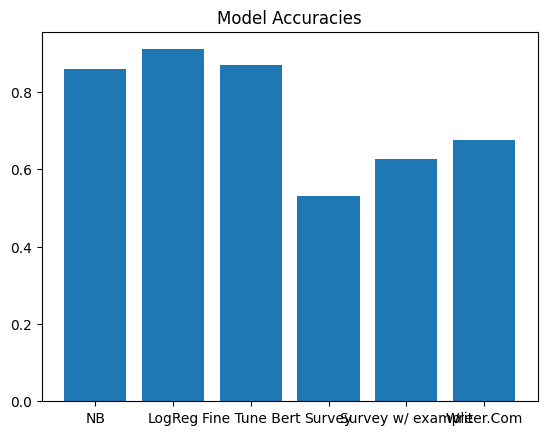

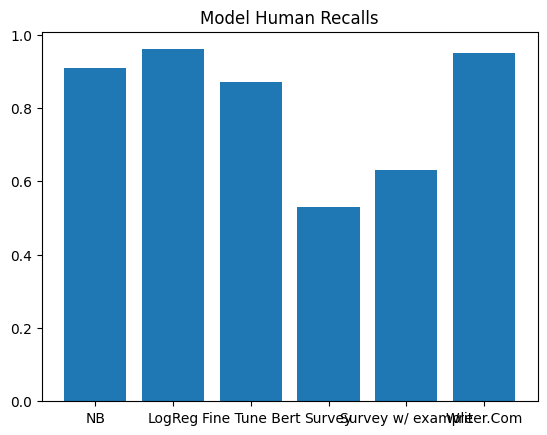

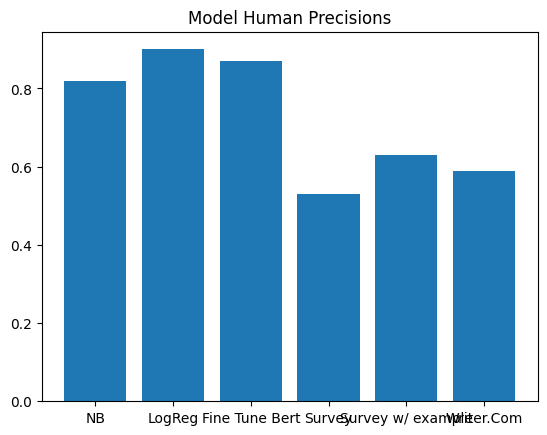

In [29]:
def compareAndPlotModelAccuracies():
    #models: Bag of Words (Naive Bayes), Pre-trained Bert (Bagged Logistic Regression), Fine-tuned Bert, Human Survey Results
    #accuracies) BoW: .9 (Naive Bayes), Pre-trained Bert (Bagged Logistic Regression): .85, Fine-Tuned Bert: 1, Human Survey Results: x
    #plot accuracies
    modelNames = ["NB", "LogReg", "Fine Tune Bert", "Survey", "Survey w/ example", "Writer.Com"]
    accuracies = [.86, .91, .87, .53, .6275, .675]
    plt.figure()
    plt.bar(modelNames, accuracies)
    plt.title("Model Accuracies")
    plt.savefig('/content/drive/My Drive/ModelAccuracies')

    plt.show()

def compareAndPlotModelHumanPrecisions():
    #models: Bag of Words (Naive Bayes), Pre-trained Bert (Bagged Logistic Regression), Fine-tuned Bert, Human Survey Results
    #accuracies) BoW: .9 (Naive Bayes), Pre-trained Bert (Bagged Logistic Regression): .85, Fine-Tuned Bert: 1, Human Survey Results: x
    #plot accuracies
    modelNames = ["NB", "LogReg", "Fine Tune Bert", "Survey", "Survey w/ example", "Writer.Com"]
    accuracies = [.82, .9, .87, .53, .63, .59]
    plt.figure()
    plt.bar(modelNames, accuracies)
    plt.title("Model Human Precisions")
    plt.savefig('/content/drive/My Drive/ModelHumanPrecisions')

    plt.show()

def compareAndPlotModelHumanRecalls():
    #models: Bag of Words (Naive Bayes), Pre-trained Bert (Bagged Logistic Regression), Fine-tuned Bert, Human Survey Results
    #accuracies) BoW: .9 (Naive Bayes), Pre-trained Bert (Bagged Logistic Regression): .85, Fine-Tuned Bert: 1, Human Survey Results: x
    #plot accuracies
    modelNames = ["NB", "LogReg", "Fine Tune Bert", "Survey", "Survey w/ example", "Writer.Com"]
    accuracies = [.91, .96, .87, .53, .63, .95]
    plt.figure()
    plt.bar(modelNames, accuracies)
    plt.title("Model Human Recalls")
    plt.savefig('/content/drive/My Drive/ModelHuman')

    plt.show()



compareAndPlotModelAccuracies()
compareAndPlotModelHumanRecalls()
compareAndPlotModelHumanPrecisions()